In [1]:
import math
import pandas as pd
import numpy as np
import networkx as nx
import csv
import random
import matplotlib.pyplot as plt
import statistics 
from scipy import stats
from scipy.spatial import distance
import io
import time#for recording time 
import sys #for getting size of object
!pip install texttable
from texttable import Texttable

plt.rcParams["figure.figsize"] = (10,10)

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [2]:
#random.seed(14)

### *Importing files from github for google colab


In [3]:
url = 'https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/contact_rules.csv'
rules_df  = pd.read_csv(url,header=None,engine='python')
url2='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/frequency_contact.csv'
frequency_df= pd.read_csv(url2,header=None,engine='python')
url3='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/population.csv'
population_df=pd.read_csv(url3,header=None,engine='python')
url4='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/skewness.csv'
skewness_df=pd.read_csv(url4,header=None,engine='python')
url5='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/Age_exact.csv'
age_exact_df=pd.read_csv(url5,header=0,engine='python')
url6='https://raw.githubusercontent.com/sobhan-moosavi/varicella_study/main/mortality.csv'
death_rate_df=pd.read_csv(url6,header=0,engine='python')

### *importing files from pc


# THE GRAPH CONTROL PANEL

In [4]:
N =10000# Number of nodes
setting='school'#the setting we are evaluating(home,work,school,other)
clustering_factor=1000 #multiplies chance of connecting with N_of_N
clustering=True
sampling_ratio=1000 #In how many iterations we calculate metrics
skewed = True
symetricality=True # if we are using original contact data or transform it to be symetrical 
birth_rate=14.4/1000 #belongs to year 2019
size_assortivity=0  #chance of connection with nodes with same count of contact(0 is off)

## 1-Defining Nodes

In [5]:
#defining a dictionary of nodes

group_popularity = dict() #based on consensus year 95
nodes_dic=dict() #dictionary of nodes
frequency=dict()
death_r=dict()
nodes_list=list()


for i, row in age_exact_df.iterrows():
    group_popularity[row[0]]=float(row[1])
    
for i, row in death_rate_df.iterrows():
    death_r[row[0]]=float(row[3])
               
for i in range(N):#deciding nodes ages
    while True:
        r=random.random()
        t=random.choice(list(group_popularity.keys()))
        if r<=group_popularity[t]:
            nodes_list.append([t])
            break

            
death_age_group=[['0_1', 0, 1], [' 1_4 ', 1, 4], [' 5_9 ', 5, 9], [' 10_14 ', 10, 14], [' 15_19  ', 15, 19], [' 20_24 ', 20, 24], [' 25_29 ', 25, 29], [' 30_34 ', 30, 34], [' 35_39 ', 35, 39], [' 40_44 ', 40, 44], [' 45_49 ', 45, 49], [' 50_54 ', 50, 54], [' 55_59 ', 55, 59], [' 60_64 ', 60, 64], [' 65_69 ', 65, 69], [' 70_74 ', 70, 74], [' 75_79 ', 75, 79], [' 80_84 ', 80, 84], ['85_200', 85, 200]]           
#changing population by birth and death to update the data
dead_nodes=[]
for i in range(1):
    #counting number of birth
    count_birth=int(abs(birth_rate*(len(nodes_list))))
    #adding to ages
    for j in range(len(nodes_list)):
        nodes_list[j][0]+=1
    #birth of nodes   
    for j in range(count_birth):
        nodes_list.append([0])  
    #death of nodes
    for j in range(len(nodes_list)):
        death_age=False
        #checking the age of node
        for k in death_age_group:
            if death_age==False:
                if nodes_list[j][0]>=k[1] and nodes_list[j][0]<=k[2]:
                    age_bucket=k[0]
                    death_age=True
                    
        r=random.random()
        #checking if node dies
        if r <= death_r[age_bucket]:
            nodes_list[j]='D'
    #removing dead nodes from list 
    while 'D' in nodes_list:
        nodes_list.remove('D')
        
#putting final list to dict        
for i in range(len(nodes_list)):
    nodes_dic[i]={'age_E':nodes_list[i][0]}
                    
#putting ages into buckets
age_groups=[['0_4', 0, 4],['5_9', 5, 9],['10_14', 10, 14],['15_19', 15, 19],['20_24', 20, 24],['25_29', 25, 29],['30_34', 30, 34],['35_39', 35, 39],['40_44', 40, 44],['45_49', 45, 49],['50_54', 50, 54],['55_59', 55, 59],['60_64', 60, 64],['65_69', 65, 69],['70_74', 70, 74],['75+', 75,200]] 
for i in nodes_dic.keys():
    bucket = False
    for j in age_groups :
        if bucket== False and nodes_dic[i]['age_E'] <= j[2] and nodes_dic[i]['age_E'] >=j[1]:
            nodes_dic[i]['age']=j[0]
            bucket=True

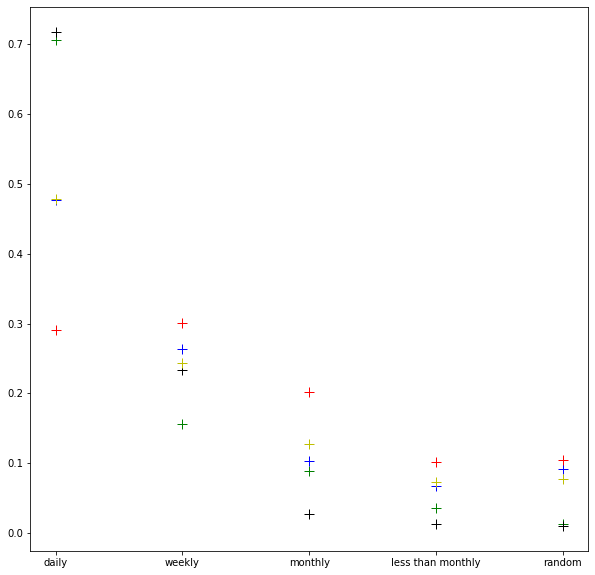

In [38]:
#importing data for frequency of contact in each setting for comparison
frequency=dict()
frequency_factor=dict()
frequency_raw=dict()
for i, row in frequency_df.iterrows():
    frequency_raw[row[0]]=dict()
    for i in range(1,6):
        frequency_raw[row[0]][i]=float(row[i])
        

        
frequency['school']={'d':1,'r':0}
frequency['home']={'d':1,'r':0}
frequency['work']={'d':.5,'r':.5}
frequency['others']={'d':.3,'r':.7}

plt.rcParams["figure.figsize"] = (10,10)
frequency_label={1:'daily',2:'weekly',3:'monthly',4:'less than monthly',5:'random'}                
colors={'home':'g+','school':'k+','work':'b+','others':'r+','all':'y+'}       
for i in frequency_raw.keys():
    for j in frequency_raw[i].keys():
        plt.plot(frequency_label[j],frequency_raw[i][j],colors[i],linewidth=2, markersize=10,alpha=1)


### Which `group` each node belongs to?

* We  used `Age specific population for Iran` to define probability of each group

In [7]:

# the number of nodes in each group:

age_count = {}
for n in nodes_dic.keys():
    if nodes_dic[n]['age'] in age_count:
        age_count[nodes_dic[n]['age']] = age_count[nodes_dic[n]['age']] + 1
    else:
        age_count[nodes_dic[n]['age']] = 1
age_count

{'5_9': 783,
 '50_54': 479,
 '30_34': 1099,
 '25_29': 936,
 '60_64': 299,
 '40_44': 743,
 '75+': 238,
 '10_14': 721,
 '0_4': 895,
 '35_39': 929,
 '15_19': 697,
 '55_59': 435,
 '20_24': 821,
 '45_49': 619,
 '65_69': 224,
 '70_74': 154}

## 2-Defining Connection Rules between Node Groups

### `We define rules in terms of connection probability between each two groups`


In [8]:
#importing rules_data from .csv to nested dictionary
rules_data={}  # rules_data contain ->{location:{contactor:{contactee:contact number}
temp_0={}
temp_1={}
location=[]
contactor=[]
contactee=[]
contact_number=[]

for i, row in rules_df.iterrows():
    
    location.append(row[0])
    contactor.append(row[1])
    contactee.append(row[2])
    contact_number.append(float(row[3]))

for o in range (0,1280,256):
    for m in range(o,o+256,16):
        for n in range (m,m+16):
            
            temp_0[contactee[n]]=contact_number[n]
        temp_1[contactor[m]]=temp_0.copy()
    rules_data[location[o]]=temp_1.copy()     

In [9]:
#transforming rules_data to rules so it will be symetrical
#It should be symetrical for building undirected graph

rules=dict()

if symetricality == False :
    
    rules=rules_data

else:

    for i in rules_data.keys():
        rules[i]=dict()
        for j in rules_data[i].keys():
            rules[i][j]=dict() 
            for k in rules_data[i][j].keys():

                total_j_k_contact=(rules_data[i][j][k]*age_count[j])+(rules_data[i][k][j]*age_count[k])
                rules[i][j][k]=(total_j_k_contact/2)/age_count[j]

In [10]:
#claculating how many contact a person has with all age groups in the setting
#calculating how many 'connectons' is required for the contacts with specific frequency
rules_sum=dict()
for s in rules.keys():
    rules_sum[s]=dict()
    for a in rules[s].keys():
        t=0
        for j in rules[s][a].keys():
            t+=rules[s][a][j]
        rules_sum[s][a]=t


table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['setting','age','contact_total']],header=True)      
print(table.draw())
for s in rules_sum.keys():
    for a in rules_sum[i].keys():
        
        table.add_rows([[s,a,'%f' % rules_sum[s][a]]],header=True)
        
        print(table.draw())

setting   age   contact_total
  all     0_4     10.367359  
  all     5_9     18.519571  
  all     10_     21.727107  
          14                 
  all     15_     19.107827  
          19                 
  all     20_     12.039117  
          24                 
  all     25_     12.307076  
          29                 
  all     30_     12.720612  
          34                 
  all     35_     13.897952  
          39                 
  all     40_     13.324077  
          44                 
  all     45_     11.069792  
          49                 
  all     50_     11.393562  
          54                 
  all     55_     9.383375   
          59                 
  all     60_     9.340562   
          64                 
  all     65_     7.946040   
          69                 
  all     70_     6.765687   
          74                 
  all     75+     3.100253   
 home     0_4     5.233858   
 home     5_9     6.126019   
 home     10_     5.709606   
          

In [11]:
#importing skewness of distribution of number of contacts for each age in each setting 
skewness={'home':{},'school':{},'work':{},'others':{}}

for i, row in skewness_df.iterrows():   
    skewness[row[0]][row[1]]={'skw':0,'loc':0,'scale':0}
    skewness[row[0]][row[1]]['skw']=row[2] 
    skewness[row[0]][row[1]]['loc']=row[3]
    skewness[row[0]][row[1]]['scale']=row[4]

In [12]:
#distrrbution is used for building synthetic distribuiton of number of contacts based on skewness data

distribution={'home':{},'school':{},'work':{},'others':{}}
for s in skewness.keys():
    for a in skewness[s].keys():
        
        mean_data=rules_sum[s][a]
            
        scale=skewness[s][a]['scale']
        distribution_model=stats.skewnorm.rvs(skewness[s][a]['skw'], loc=skewness[s][a]['loc'], scale=scale, size=1000, random_state=None)
          
        mean_model=statistics.mean(distribution_model)
        
        if mean_data==0 :
            
            distribution_model=[0]    
            distribution[s][a]=distribution_model
             
                
        elif mean_data !=0:
            
            #grid search for finding optimum 'scale'
            x=0
            while abs(mean_model-mean_data) > .01 :


                if mean_model - mean_data > 0 :
                    scale-=.01
                elif mean_model - mean_data < 0:
                    scale+=.01
                x+=1

                distribution_model=stats.skewnorm.rvs(skewness[s][a]['skw'], loc=skewness[s][a]['loc'], scale=scale, size=1000, random_state=None)
                #rounding the values in distribution
                n=0
                for i in distribution_model:

                    distribution_model[n]=round(i)
                    n+=1
                mean_model=statistics.mean(distribution_model)
            
            distribution[s][a]=distribution_model

print('Done')


Done


## 3-Defining Functions



### 3-1 function run : builds the graph based on rules of connections

In [13]:
#in this block we've defiend a function "Run" 
def Run(nodes_dic,age_count,frequency,size_assortivity):
    
    #building the array based on nodes_dic
    #graph_array=[N * [[connecetions],number of the node,number of connections]
    graph_array=[]
    for i in nodes_dic.keys():
        Age_i=nodes_dic[i]['age']
        #determining number of conections based on number of contacts
        # if skewness is considered or not
        if skewed == True :
            Num_contact = random.choice(distribution[setting][Age_i])
        elif skewed == False :
            Num_contact=np.random.poisson(lam=rules_sum[setting][Age_i]['contact_total'])
        #number of random contacts for the node
        R_contact=round(Num_contact*frequency[setting]['r']) 
        
        graph_array.append([[],i,Num_contact,R_contact])
 
    #making a dictionary that consists of lists of nodes in each age group
    nodes_age_grouped=dict() 
    for i in nodes_dic.keys():     
        if nodes_dic[i]['age'] in nodes_age_grouped:
            nodes_age_grouped[nodes_dic[i]['age']].append(i)    
        else:
            nodes_age_grouped[nodes_dic[i]['age']]=[i]
            
            
    #for storing metrics during run
    samples_T={'mean absoloute error': [], 'Manhattan distance': [], 'Euclidean distance': [], 'Chebyshev distance': []}
    
    
                            
    #for calculating sampling_ratio               
    sampling_counter=0                                       
    #building complete graph
    print('building complete graph ...')
    for contactor in nodes_dic.keys():
        
        #taking a picture of graph for monitoring it's evoloution
        sampling_counter+=1
        
        if sampling_counter == sampling_ratio :
            
            sampling_counter=0
            #calculating metrics for graph at the moment
            samples=sampling(N,graph_array,age_count,rules)
            #storing the metrics
            for metric in samples_T.keys():
                samples_T[metric].append(samples[metric])
            
        Age_contactor=nodes_dic[contactor]['age']
        
        #claculating remaining number of connections to build  
        #total number of contact - number of random contacts - contacts already built
        counter = graph_array[contactor][2]-graph_array[contactor][3]-len(graph_array[contactor][0])
        
        dead_end=False #for checking if there is not enough empty spots to connect this node
        #completing graph 
        
        #building primary list of N_of_N
        N_of_N=list()
        
        for j in graph_array[contactor][0]:

            for k in graph_array[j][0]:
                
                if k!=contactor and k not in graph_array[contactor][0]:
                    
                    N_of_N.append(k)

        N_of_N=list(set(N_of_N))
                
        while counter > 0 and not dead_end :
            
            #connecting to N_of_N and making triangels
            if clustering :
                
                #for i in range(clustering_factor):

                #iterating in N_of_N to make connections
                for contactee in N_of_N :

                    if counter > 0 :

                        Age_C=nodes_dic[contactee]['age']
                        prob_connection=rules[setting][Age_contactor][Age_C]/(rules_sum[setting][Age_contactor]*age_count[Age_C])
                        r=random.random()
                        #checking if contactee has free capacity
                        capacity=graph_array[contactee][2]-graph_array[contactee][3]
                        if len(graph_array[contactee][0]) < capacity :
                            if r <= (prob_connection**(1/clustering_factor)) and contactee not in graph_array[contactor][0]:

                                    counter-=1

                                    graph_array[contactor][0].append(contactee)
                                    graph_array[contactee][0].append(contactor)

                                    #updating N_of_N based on the new node
                                    for l in graph_array[contactee][0]:
                                        if l != contactor and l not in graph_array[contactor][0]:
                                            N_of_N.append(l)
              
                        
                                        
            
            #making random connections if N_of_N doesn't have enouhg nodes
            if counter > 0:
                
                counter_null_iteration=0#counts number of iterations that fail to form connection
                random_connection =False
                while random_connection == False and not dead_end :
                    
                    #deciding age of connection
                    Age_C=random.choice(list(nodes_age_grouped.keys()))
                    r=random.random()
                    prob_connection=rules[setting][Age_contactor][Age_C]/(rules_sum[setting][Age_contactor])
                    
                    
                    if r <= prob_connection:
                        #deciding a random node from the chosen age group to make connection

                        contactee= random.choice(list(nodes_age_grouped[Age_C]))
                        counter_null_iteration+=1
                            
                        #checking contactee for capacity of new connections
                        capacity=graph_array[contactee][2]-graph_array[contactee][3]
                        if len(graph_array[contactee][0]) < capacity:
                            
                            #optimizing probability of contact based on number of connections of each node
                            if graph_array[contactee][2]-graph_array[contactor][2]<0:
                                size_prob=graph_array[contactor][2]/graph_array[contactee][2]
                            else:
                                size_prob=graph_array[contactee][2]/graph_array[contactor][2]
                
                            r=random.random()

                            if r < size_prob**size_assortivity:
                            
                                if contactee not in graph_array[contactor][0] and contactee != contactor :

                                    random_connection = True
                                    counter-=1

                                    graph_array[contactor][0].append(contactee)
                                    graph_array[contactee][0].append(contactor)

                                    #building N_of_N based on newly added node
                                    N_of_N=[]

                                    for j in graph_array[contactee][0]:
                                        if j!=contactor and j not in graph_array[contactor][0]:     
                                            N_of_N.append(j)
                                        
                        #if we have iterated 1000 times without forming connection the node is in dead end
                        if counter_null_iteration > 10000 :
                            dead_end=True
                            print(contactor,'hit dead end')
##################################################
#putting data from graph to a list of connections
    connections_list=list()
    for i in nodes_dic.keys():
        for j in range(len(graph_array[i][0])):
            k=graph_array[i][0][j]
        
            if i<k:
                connections_list.append((i,k))
            elif k<i:
                connections_list.append((k,i))
    #removing duplicates
    connections_list=list(set(connections_list))
    
                             
    results={'graph_array':graph_array,'nodes_age_grouped':nodes_age_grouped,'connections':connections_list,'samples_T':samples_T}                           
    return(results)


### 3-2 function Run_S imports graph and checks for connections in each day 

In [14]:
#Run_S runs the model and stores conections but do not change the weights
def Run_S (nodes_dic,N_day,rules,age_count,N,results):
    
    list_weight={'d':0,'r':0}
    
    nodes_age_grouped=results['nodes_age_grouped']
    graph_array=results['graph_array']
    connections=results['connections']
    

    #in this list the day that connection has happened is stored
    #contacts=[N*[[daily],[random]]]
    contacts=[] 
    for i in nodes_dic.keys():
        contacts.append([[],[]])
        #[[daily connections],[random connections]]
    
    #storing contacts that daily happen   
    for contactor in graph_array:
        for contactee in contactor[0]:

            #we determine contact by the neighbor that comes first to avoid duplication
            if contactor[1]<contactee:

                contacts[contactor[1]][0].append(contactee)
                contacts[contactee][0].append(contactor[1])
                list_weight['d']+=1

        count_random=(contactor[3]-len(contacts[contactor[1]][1]))
        
        n=0#for avoiding blocks
        for k in range(count_random):

            while n<10000:
                r=random.random()
                #deciding the age of connection of the node
                Age_contactor=nodes_dic[contactor[1]]['age']
                Age_C=random.choice(list(nodes_age_grouped.keys()))
                r=random.random()
                
                prob_connection=rules[setting][Age_contactor][Age_C]/(rules_sum[setting][Age_contactor])

                if rules[setting][Age_contactor][Age_C]!=0:
                    if r <= prob_connection:
                        #deciding a random node from the chosen age group to make connection
                        contactee=random.choice(nodes_age_grouped[Age_C])
                        n+=1
                         #making sure contactee has capacity for random connection
                        capacity=graph_array[contactee][3]-len(contacts[contactee][1])
                        if capacity > 0 :   
                            #making sure contactee and contactor had no connection and no contact before
                            if (contactee not in contactor[0]) and (contactee not in contacts[contactor[1]][1]):
                                contacts[contactor[1]][1].append(contactee)
                                contacts[contactee][1].append(contactor[1])
                                list_weight['r']+=1
                                break
    contacts_merged=[]                          
    for i in contacts:
        merged=i[0]+i[1]
        contacts_merged.append(merged)
        
    Run_S_result={'contacts':contacts_merged,'frequency':list_weight}     
    return(Run_S_result)



### 3-3 function sampling checks the graph and calculates metrics during the run

In [15]:
#this function claculates metric for graph during the run

def sampling(N,graph_array,age_count,rules):
    #builds list of contacts based on current situation of graph
    contacts=[]
    for node in nodes_dic.keys():
        contacts.append([])
        contacts[node].append(graph_array[node][0])
    #calculates metrics    
    Metr_W= Metric_W_P(contacts,age_count,rules)
    
    samples={'mean absoloute error':Metr_W['M_Abs'],'Manhattan distance':Metr_W['man_dis'],'Euclidean distance':Metr_W['eu_dis'],'Chebyshev distance':Metr_W['cheb_dis']}
     
    return(samples)

### 3-4 function Metric_w calculates metrics for the input graph

In [16]:
#this function returns measures for comparison age stratified number of contacts
#for evaluation of full model


def Metric_W(sample_run,age_count,rules) : 
    
    
    L1=[]
    L2=[]
    L3=[]
    contacts=sample_run['contacts']
    
    #building empty dictionary based on rules
    rules_m=dict()
    rules_m[setting]=dict()
    

    for i in rules[setting].keys():
        rules_m[setting][i]=dict()
        for j in rules[setting][i].keys():
             rules_m[setting][i][j]=0
    
    for i in nodes_dic.keys():
        for j in contacts[i]:
            
            age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]
            if i!=j and age_p!=0 : 
                t= 1/age_count[nodes_dic[i]['age']]
                rules_m[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]+=t
                         
    for i in rules_m[setting].keys():
        for j in rules_m[setting][i].keys():
            
            L1.append(rules[setting][i][j])
            L2.append(rules_m[setting][i][j])
            
            L3.append(abs((rules_m[setting][i][j])-(rules[setting][i][j])))
    
                
                
    wilx=stats.wilcoxon(L1,L2,zero_method='wilcox', correction=False, alternative='two-sided')
    
    M_Abs=statistics.mean(L3)
    #Manhattan distance
    man_dis=distance.cityblock(L1, L2)
    #Euclidean distance
    eu_dis=distance.euclidean(L1,L2)
    #Chebyshev distance
    cheb_dis=distance.chebyshev(L1,L2)
    #Pearson corelation
    prs_cor=stats.pearsonr(L1,L2)
    
    
    Metric_W ={'wilx':wilx,'M_Abs':M_Abs,'rules_m':rules_m,'L3':L3,'man_dis':man_dis,'eu_dis':eu_dis,'cheb_dis':cheb_dis, 'prs_cor': prs_cor}
    
    return(Metric_W)

In [17]:
#this function returns measures for comparison age stratified number of contacts
#for evaluation of progression model


def Metric_W_P(graph_array,age_count,rules) : 
    
    
    L1=[]
    L2=[]
    L3=[]
    
    #building empty dictionary based on rules
    rules_m=dict()
    rules_m[setting]=dict()

    for i in rules[setting].keys():
        rules_m[setting][i]=dict()
        for j in rules[setting][i].keys():
             rules_m[setting][i][j]=0
    
    for i in nodes_dic.keys():
            for j in graph_array[i][0]:
                age_p=rules[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]
                if i!=j and age_p!=0 : 
                    t= 1/age_count[nodes_dic[i]['age']]
                    rules_m[setting][nodes_dic[i]['age']][nodes_dic[j]['age']]+=t
                         
    for i in rules_m[setting].keys():
        for j in rules_m[setting][i].keys():
            
            L1.append(rules[setting][i][j]*frequency[setting]['d'])
            L2.append(rules_m[setting][i][j])
            
            L3.append(abs((rules_m[setting][i][j])-(rules[setting][i][j]*frequency[setting]['d'])))
    
                
    M_Abs=statistics.mean(L3)
    #Manhattan distance
    man_dis=distance.cityblock(L1, L2)
    #Euclidean distance
    eu_dis=distance.euclidean(L1,L2)
    #Chebyshev distance
    cheb_dis=distance.chebyshev(L1,L2)
    #Pearson corelation
    prs_cor=stats.pearsonr(L1,L2)
    
    
    Metric_W ={'M_Abs':M_Abs,'rules_m':rules_m,'L3':L3,'man_dis':man_dis,'eu_dis':eu_dis,'cheb_dis':cheb_dis, 'prs_cor': prs_cor}
    
    return(Metric_W)

### 3-5 function clustering_coefficent calculate number of triangles and ratio of contacts involved in a triangel compared to total  contacts with possibility of forming triangles

In [18]:
#claculate clustering by counting number of triangels
def clustering_rate (results):
    
   
    graph_array=results['graph_array']
    t_triangel=0
    t_contact=0
    all_contact=0
    for node in nodes_dic.keys():
        
        for i in graph_array[node][0]:
            all_contact+=1
        
        if len(graph_array[node][0])>1:
            #building list of neighbor of neighbors
            N_of_N=[]
            for neighbor in graph_array[node][0]:
                for neighbor2 in graph_array[neighbor][0]:
                    N_of_N.append(neighbor2)
            #checking for triangels

            for neighbor in graph_array[node][0]:
                #if it's possible for the node to build triangels
                
                if len(graph_array[neighbor][0])>1:
                    t_contact+=1
                if neighbor in N_of_N :
                    t_triangel += 1
                    
                    
                
    t_contact=t_contact/2 
    t_triangel=t_triangel/2
    all_contact=all_contact/2
    clustering_coefficent=(t_triangel)/t_contact
    clustering_ratio=(t_triangel + (all_contact-t_contact))/all_contact
                
    return(t_triangel,clustering_coefficent,clustering_ratio)

# 4-Running the model
### the functions run in this part




In [19]:
start = time.time()

In [20]:
#this part runs the model
results=Run(nodes_dic,age_count,frequency,size_assortivity)


building complete graph ...
9599 hit dead end
9602 hit dead end
9791 hit dead end


In [21]:
end=time.time()

In [22]:
#running a 1 day simulation of model
sample_run=Run_S(nodes_dic,1,rules,age_count,N,results)

In [23]:
#this part returns the measures for age stratified number of contact
Metr_W=Metric_W(sample_run,age_count,rules)


# 5-Reporitng the model

### 5-1 Table of mean number of contact per age both from data and model 


In [24]:
#this part shows number of age stratified contact from data and model for comparision
t=0
L3=Metr_W['L3']
table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['age i','age j','rules_m  ',' rules  ','Abs_error']])

print(table.draw())

for i in rules[setting].keys():
    
    for j in rules[setting][i].keys():
        
        model=Metr_W["rules_m"][setting][i][j]
        data=rules[setting][i][j]
        table.add_rows([[i,j,'%f' %  model,'%f' % data,'%f' % L3[t]]])
        print(table.draw())
        t+=1

        

age i   age j    rules_m      rules    Abs_error
 0_4     0_4    0.339665    0.329770   0.009895 
 0_4     5_9    0.157542    0.172016   0.014474 
 0_4    10_14   0.017877    0.015503   0.002374 
 0_4    15_19   0.011173    0.016418   0.005244 
 0_4    20_24   0.006704    0.007911   0.001208 
 0_4    25_29   0.007821    0.003377   0.004444 
 0_4    30_34   0.004469    0.007257   0.002788 
 0_4    35_39   0.006704    0.006956   0.000252 
 0_4    40_44   0.003352    0.002959   0.000393 
 0_4    45_49   0.005587    0.008725   0.003139 
 0_4    50_54   0.004469    0.003072   0.001397 
 0_4    55_59   0.004469    0.005552   0.001083 
 0_4    60_64   0.002235    0.001780   0.000454 
 0_4    65_69   0.000000    0.000140   0.000140 
 0_4    70_74   0.000000    0.000000   0.000000 
 0_4     75+    0.000000    0.000000   0.000000 
 5_9     0_4    0.180077    0.196621   0.016545 
 5_9     5_9    5.655172    6.015030   0.359858 
 5_9    10_14   1.185185    0.768168   0.417017 
 5_9    15_19   0.13

### 5-2 heat map of number of contact per age ,for data,model and the diffrence of them

graph of data


<ipython-input-25-dcb881747886>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(range(0,16,1),range(0,16,1),color_graph, cmap='coolwarm',vmin=0,vmax=V_max)


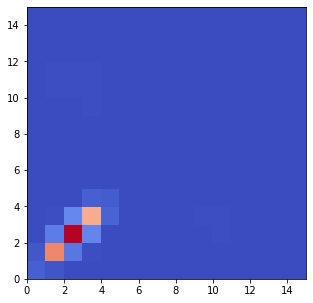

graph of model


<ipython-input-25-dcb881747886>:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(range(0,16,1),range(0,16,1),color_graph_m, cmap='coolwarm',vmin=0,vmax=V_max)


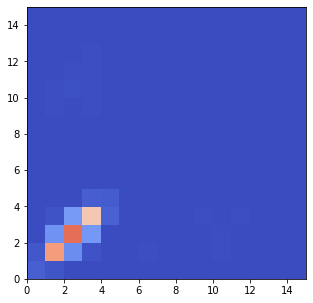

differences


<ipython-input-25-dcb881747886>:49: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolor(range(0,16,1),range(0,16,1),color_graph_dif, cmap='coolwarm')


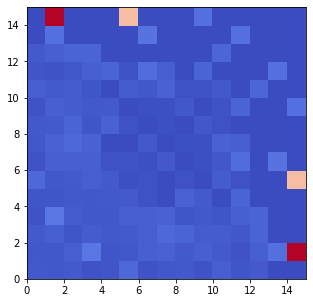

In [25]:
#heat map

plt.rcParams["figure.figsize"] = (5,5)

color_graph=[]

V_max=0 

for i in rules[setting].keys():
    color_graph.append([])
    for j in rules[setting][i]:
        color_graph[-1].append(rules[setting][i][j])
        if V_max<rules[setting][i][j]:
            V_max=rules[setting][i][j]
    
print('graph of data')       
plt.pcolor(range(0,16,1),range(0,16,1),color_graph, cmap='coolwarm',vmin=0,vmax=V_max)
plt.show()

color_graph_m=[]

for i in Metr_W["rules_m"][setting].keys():
    color_graph_m.append([])
    for j in Metr_W["rules_m"][setting][i]:
        color_graph_m[-1].append(Metr_W["rules_m"][setting][i][j])
        if V_max<Metr_W["rules_m"][setting][i][j]:
            V_max=Metr_W["rules_m"][setting][i][j]
    

print('graph of model')          
plt.pcolor(range(0,16,1),range(0,16,1),color_graph_m, cmap='coolwarm',vmin=0,vmax=V_max)
plt.show()

color_graph_dif=[]


for i in Metr_W["rules_m"][setting].keys():
    color_graph_dif.append([])
    for j in Metr_W["rules_m"][setting][i]:
        if rules[setting][i][j] != 0 :
            diff=Metr_W["rules_m"][setting][i][j]/rules[setting][i][j]
            color_graph_dif[-1].append(diff)
        elif rules[setting][i][j] == 0 :
            diff=0
            color_graph_dif[-1].append(diff)
        
            
print('differences')          
plt.pcolor(range(0,16,1),range(0,16,1),color_graph_dif, cmap='coolwarm')
plt.show()

### 5-3 metrics used for comparison of model and data

In [26]:
#this part returns p_value wilcoxon for comparison age stratified number of contacts 

print('p-value wilcoxon :','%f' % Metr_W['wilx'][1])

print('Pearson Corealtion :',Metr_W['prs_cor'][0],'%f' % Metr_W['prs_cor'][1])

print('mean absoloute error : ', Metr_W['M_Abs'])

print('Manhattan distance :',Metr_W['man_dis'])

print('Euclidean distance :',Metr_W['eu_dis'])

print('Chebyshev distance :',Metr_W['cheb_dis'])

p-value wilcoxon : 0.918533
Pearson Corealtion : 0.9938627480445092 0.000000
mean absoloute error :  0.018455340579382484
Manhattan distance : 4.724567188321915
Euclidean distance : 1.6157093356678014
Chebyshev distance : 1.1801651594999223


### 5-4 time of running the model

In [27]:
print(end-start)

3.9018683433532715


### 5-5 evaluation for clustring 

In [28]:
Clus=clustering_rate (results)
print('Num_triangel',Clus[0],'clustering_coefficent',Clus[1],'clustering_ratio',Clus[2])


Num_triangel 6913.0 clustering_coefficent 0.8456269113149847 clustering_ratio 0.8654297291533376


### 5-6 number of contacts in model and expected form data 

In [29]:

table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([['source',' number of contacts']])
print(table.draw())

list_contacts={'data':0,'model':0}
#based on rules_sum
for i in rules_sum[setting].keys():

    list_contacts['data']+=rules_sum[setting][i]*age_count[i]
    
#based on contacts
for i in sample_run['contacts']:
    list_contacts['model']+=len(i)


for i in list_contacts.keys():
    
    table.add_rows([[i,'%f' %list_contacts[i]]])
    print(table.draw())
    
table.add_rows([['difference','%f' %(list_contacts['model']-list_contacts['data'])]])
print(table.draw())

        

source    number of contacts
 data       18963.519590    
model       18756.000000    
differ       -207.519590    
 ence                       


### 5-7 mean number of connections for each age in model and data

 age    house hold size data   house hold size model   population
 0_4          0.581437               0.572067            0.0895  
 5_9          7.164922               7.337165            0.0783  
10_14         9.596247               9.285714            0.0721  
15_19         6.984867               6.816356            0.0697  
20_24         0.682412               0.666261            0.0821  
25_29         0.057840               0.052350            0.0936  
30_34         0.068329               0.077343            0.1099  
35_39         0.060320               0.074273            0.0929  
40_44         0.079557               0.069987            0.0743  
45_49         0.111139               0.113086            0.0619  
50_54         0.178289               0.187891            0.0479  
55_59         0.139748               0.140230            0.0435  
60_64         0.055527               0.066890            0.0299  
65_69         0.022320               0.022321            0.0224  
70_74     

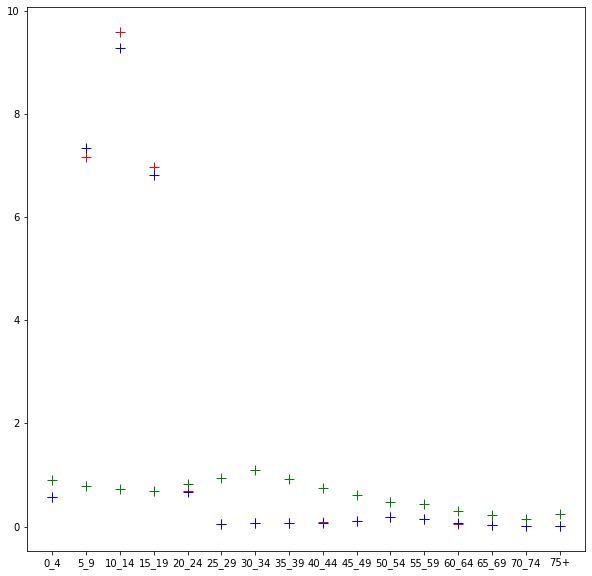

In [30]:
table=Texttable()
table.set_deco(Texttable.HEADER)
table.add_rows([[' age ','house hold size data','house hold size model','population']])
print(table.draw())
plt.rcParams["figure.figsize"] = (10,10)

house_hold_size={}
for i in age_count.keys():
    house_hold_size[i]=0
    
for i in list(enumerate(sample_run['contacts'])):
    
    Age=nodes_dic[i[0]]['age']
    house_hold_size[Age]+=(len(i[1])/age_count[Age])

for i in rules_sum[setting].keys():
    
    table.add_rows([[i,'%f' %rules_sum[setting][i],'%f' %house_hold_size[i],age_count[i]/N]])
    print(table.draw())
    plt.plot(i,rules_sum[setting][i],'r+',linewidth=2, markersize=10,alpha=1)
    plt.plot(i,house_hold_size[i],'b+',linewidth=2, markersize=10,alpha=1)
    plt.plot(i,age_count[i]/(N/10),'g+',linewidth=2, markersize=10,alpha=1)

### 5-8 progress of metrics while model runs

mean absoloute error


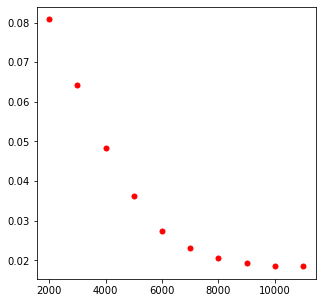

Manhattan distance


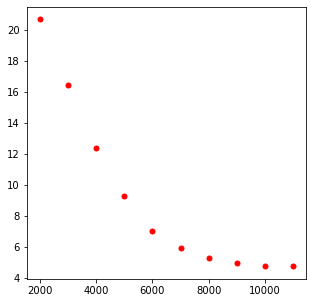

Euclidean distance


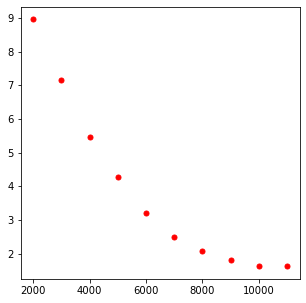

Chebyshev distance


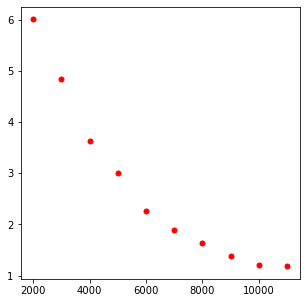

In [31]:
plt.rcParams["figure.figsize"] = (5,5)
samples=results['samples_T']
for metric in samples.keys():
    plt.show()
    print(metric)
    n_sample=sampling_ratio
    for i in samples[metric]:
        n_sample+=sampling_ratio
        plt.plot(n_sample,i,'r.',linewidth=2, markersize=10,alpha=1)
        

## 6-exporting graph

In [32]:
#exporting graph for visualization in gephi
#returns undirected graph
graph_export=list()
temp_row=list()
graphed_nodes=list()

for node in results['graph_array']:
    
    temp_row.append(node[1])
    graphed_nodes.append(node[1])
    for neighbor in node[0]:
        if neighbor not in graphed_nodes:
            temp_row.append(neighbor)
        
    graph_export.append(temp_row)
    temp_row=[]
               
graph_export_df=pd.DataFrame(graph_export)          
graph_export_df.to_csv('graph_export.csv', index = False,header=False,sep=';')  


In [33]:
n=sample_run['frequency']['d']+sample_run['frequency']['r']
print(sample_run['frequency']['d']/n,sample_run['frequency']['r']/n)
print(frequency[setting]['d'],frequency[setting]['r'])


1.0 0.0
1 0


In [34]:
results['graph_array'][50]

[[], 50, 0.0, 0]